In [1]:
import pandas as pd
filename = "/kaggle/input/targeted-marketing/hist.csv"
df = pd.read_csv(filename)
df.head()

,01,1,B,2,M,1.1,1.2
0,1,2,A,38,F,2,0
1,1,3,C,46,M,3,0
2,1,4,B,35,M,4,0
3,1,5,B,22,M,5,1
4,1,6,B,39,F,6,1


In [2]:
df.rename(columns={
    '01': 'week_id',
    '1': 'customer_id',
    'B': 'attribute1',
    '2': 'state_id',
    'M': 'Sex',
    '1.1': 'campaign_id',
    '1.2': 'response'
}, inplace=True)
df.head()

,week_id,customer_id,attribute1,state_id,Sex,campaign_id,response
0,1,2,A,38,F,2,0
1,1,3,C,46,M,3,0
2,1,4,B,35,M,4,0
3,1,5,B,22,M,5,1
4,1,6,B,39,F,6,1


In [3]:
df_extended = df.copy()
df_extended.head()

,week_id,customer_id,attribute1,state_id,Sex,campaign_id,response
0,1,2,A,38,F,2,0
1,1,3,C,46,M,3,0
2,1,4,B,35,M,4,0
3,1,5,B,22,M,5,1
4,1,6,B,39,F,6,1


In [4]:
import numpy as np
df_extended['is_female'] = np.where(df_extended['Sex'] == 'F', 1, 0)
df_extended['is_male'] = np.where(df_extended['Sex'] == 'M', 1, 0)

user_categories = pd.get_dummies(df_extended['attribute1'], prefix='category')
df_extended = pd.concat([df_extended, user_categories], axis=1)

In [5]:
df_extended=df_extended.drop(['Sex','attribute1'],axis=1)
df_extended.head()

,week_id,customer_id,state_id,campaign_id,response,is_female,is_male,category_A,category_B,category_C,category_D
0,1,2,38,2,0,1,0,True,False,False,False
1,1,3,46,3,0,0,1,False,False,True,False
2,1,4,35,4,0,0,1,False,True,False,False
3,1,5,22,5,1,0,1,False,True,False,False
4,1,6,39,6,1,1,0,False,True,False,False


In [6]:
df_extended = df_extended.sort_values(by=['customer_id', 'week_id'])
df_extended['LAST_CAMPAIGN'] = df_extended.groupby('customer_id')['campaign_id'].shift(1)
df_extended['LAST_2ND_CAMPAIGN'] = df_extended.groupby('customer_id')['campaign_id'].shift(2)
df_extended['IS_LAST_A_RESPONSE'] = df_extended.groupby('customer_id')['response'].shift(1)

state_response_rate = df_extended.groupby('state_id')['response'].mean()
df_extended['State_response_rate'] = df_extended['state_id'].map(state_response_rate)
df_extended.head()

,week_id,customer_id,state_id,campaign_id,response,is_female,is_male,category_A,category_B,category_C,category_D,LAST_CAMPAIGN,LAST_2ND_CAMPAIGN,IS_LAST_A_RESPONSE,State_response_rate
9999,2,1,2,2,0,0,1,False,True,False,False,NaN,NaN,NaN,0.447439
19999,3,1,2,3,0,0,1,False,True,False,False,2.0,NaN,0.0,0.447439
29999,4,1,2,4,0,0,1,False,True,False,False,3.0,2.0,0.0,0.447439
39999,5,1,2,5,0,0,1,False,True,False,False,4.0,3.0,0.0,0.447439
49999,6,1,2,6,1,0,1,False,True,False,False,5.0,4.0,0.0,0.447439


In [7]:
def compute_last_response_week(group):
    last_response = group['week_id'].where(group['response'] == 1).ffill().fillna(0)
    return last_response

df_extended['last_response_week'] = df_extended.groupby('customer_id').apply(compute_last_response_week).reset_index(level=0, drop=True)
df_extended['WEEK_SINCE_LAST_RESPONSE'] = df_extended['week_id'] - df_extended['last_response_week']
df_extended.drop(columns=['last_response_week'], inplace=True)

/tmp/ipykernel_34/2573778662.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_extended['last_response_week'] = df_extended.groupby('customer_id').apply(compute_last_response_week).reset_index(level=0, drop=True)


In [8]:
df_extended['FRQ_W_2'] = 0
df_extended['FRQ_W_3'] = 0
df_extended['FRQ_W_4'] = 0
df_extended['FRQ_W_5'] = 0
df_extended['LIFE_TIME_RESPONSE_RATE'] = 0.0

for customer_id in df_extended['customer_id'].unique():
    customer_data = df_extended[df_extended['customer_id'] == customer_id]
    for index, row in customer_data.iterrows():
        current_week = row['week_id']
        responses = customer_data[customer_data['response'] == 1]
        
        df_extended.loc[index, 'FRQ_W_2'] = len(responses[(responses['week_id'] >= current_week - 2) & (responses['week_id'] < current_week)])
        df_extended.loc[index, 'FRQ_W_3'] = len(responses[(responses['week_id'] >= current_week - 3) & (responses['week_id'] < current_week)])
        df_extended.loc[index, 'FRQ_W_4'] = len(responses[(responses['week_id'] >= current_week - 4) & (responses['week_id'] < current_week)])
        df_extended.loc[index, 'FRQ_W_5'] = len(responses[(responses['week_id'] >= current_week - 5) & (responses['week_id'] < current_week)])

In [9]:
df_extended.head()

,week_id,customer_id,state_id,campaign_id,response,is_female,is_male,category_A,category_B,category_C,...,LAST_CAMPAIGN,LAST_2ND_CAMPAIGN,IS_LAST_A_RESPONSE,State_response_rate,WEEK_SINCE_LAST_RESPONSE,FRQ_W_2,FRQ_W_3,FRQ_W_4,FRQ_W_5,LIFE_TIME_RESPONSE_RATE
9999,2,1,2,2,0,0,1,False,True,False,...,NaN,NaN,NaN,0.447439,2.0,0,0,0,0,0.0
19999,3,1,2,3,0,0,1,False,True,False,...,2.0,NaN,0.0,0.447439,3.0,0,0,0,0,0.0
29999,4,1,2,4,0,0,1,False,True,False,...,3.0,2.0,0.0,0.447439,4.0,0,0,0,0,0.0
39999,5,1,2,5,0,0,1,False,True,False,...,4.0,3.0,0.0,0.447439,5.0,0,0,0,0,0.0
49999,6,1,2,6,1,0,1,False,True,False,...,5.0,4.0,0.0,0.447439,0.0,0,0,0,0,0.0


In [10]:
import pandas as pd

df_extended['LIFE_TIME_RESPONSE_RATE'] = 0.0
def calculate_lifetime_response_rate(group):
    group['LIFE_TIME_RESPONSE_RATE'] = (group['response'].cumsum() / group['week_id']).fillna(0) * 100
    return group
df_extended = df_extended.groupby('customer_id').apply(calculate_lifetime_response_rate)
df_extended['LIFE_TIME_RESPONSE_RATE'] = df_extended['LIFE_TIME_RESPONSE_RATE'].astype(float)

/tmp/ipykernel_34/1480513491.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_extended = df_extended.groupby('customer_id').apply(calculate_lifetime_response_rate)


In [11]:
df_extended[df_extended['customer_id']==3].head(20)

week_id  customer_id  state_id  campaign_id  response  \
customer_id                                                                 
3           1             1            3        46            3         0   
            10001         2            3        46            4         1   
            20001         3            3        46            5         1   
            30001         4            3        46            6         1   
            40001         5            3        46            7         1   
            50001         6            3        46            8         0   
            60001         7            3        46            9         0   
            70001         8            3        46           10         1   
            80001         9            3        46            1         0   
            90001        10            3        46            2         0   
            100001       11            3        46            3         0   
            110001       12            3        46            4         0   
            120001       13            3        46            5         1   
            130001       14            3        46            6         1   
            140001       15            3        46            7         1   
            150001       16            3        46            8         0   
            160001       17            3        46            9         0   
            170001       18            3        46           10         1   
            180001       19            3        46            1         0   
            190001       20            3        46            2         1   

                    is_female  is_male  category_A  category_B  category_C  \
customer_id                                                                  
3           1               0        1       False       False        True   
            10001           0        1       False       False        True   
            20001           0        1       False       False        True   
            30001           0        1       False       False        True   
            40001           0        1       False       False        True   
            50001           0        1       False       False        True   
            60001           0        1       False       False        True   
            70001           0        1       False       False        True   
            80001           0        1       False       False        True   
            90001           0        1       False       False        True   
            100001          0        1       False       False        True   
            110001          0        1       False       False        True   
            120001          0        1       False       False        True   
            130001          0        1       False       False        True   
            140001          0        1       False       False        True   
            150001          0        1       False       False        True   
            160001          0        1       False       False        True   
            170001          0        1       False       False        True   
            180001          0        1       False       False        True   
            190001          0        1       False       False        True   

                    ...  LAST_CAMPAIGN  LAST_2ND_CAMPAIGN  IS_LAST_A_RESPONSE  \
customer_id         ...                                                         
3           1       ...            NaN                NaN                 NaN   
            10001   ...            3.0                NaN                 0.0   
            20001   ...            4.0                3.0                 1.0   
            30001   ...            5.0                4.0                 1.0   
            40001   ...            6.0                5.0                 1.0   
            50001   ...            7.0   

In [12]:
df_extended.fillna(0, inplace=True)

In [13]:
df_extended.isna().sum()

week_id                     0
customer_id                 0
state_id                    0
campaign_id                 0
response                    0
is_female                   0
is_male                     0
category_A                  0
category_B                  0
category_C                  0
category_D                  0
LAST_CAMPAIGN               0
LAST_2ND_CAMPAIGN           0
IS_LAST_A_RESPONSE          0
State_response_rate         0
WEEK_SINCE_LAST_RESPONSE    0
FRQ_W_2                     0
FRQ_W_3                     0
FRQ_W_4                     0
FRQ_W_5                     0
LIFE_TIME_RESPONSE_RATE     0
dtype: int64

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = df_extended.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
df_extended['WEEK_SINCE_LAST_RESPONSE'] = pd.qcut(df_extended['WEEK_SINCE_LAST_RESPONSE'], q=10, labels=False, duplicates='drop')

In [ ]:
df_extended.head()

week_id  customer_id  state_id  campaign_id  response  \
customer_id                                                                
1           9999         2            1         2            2         0   
            19999        3            1         2            3         0   
            29999        4            1         2            4         0   
            39999        5            1         2            5         0   
            49999        6            1         2            6         1   

                   is_female  is_male  category_A  category_B  category_C  \
customer_id                                                                 
1           9999           0        1       False        True       False   
            19999          0        1       False        True       False   
            29999          0        1       False        True       False   
            39999          0        1       False        True       False   
            49999          0        1       False        True       False   

                   ...  LAST_CAMPAIGN  LAST_2ND_CAMPAIGN  IS_LAST_A_RESPONSE  \
customer_id        ...                                                         
1           9999   ...            0.0                0.0                 0.0   
            19999  ...            2.0                0.0                 0.0   
            29999  ...            3.0                2.0                 0.0   
            39999  ...            4.0                3.0                 0.0   
            49999  ...            5.0                4.0                 0.0   

                   State_response_rate  WEEK_SINCE_LAST_RESPONSE  FRQ_W_2  \
customer_id                                                                 
1           9999              0.447439                         1        0   
            19999             0.447439                         2        0   
            29999             0.447439                         2        0   
            39999             0.447439                         3        0   
            49999             0.447439                         0        0   

                   FRQ_W_3  FRQ_W_4  FRQ_W_5  LIFE_TIME_RESPONSE_RATE  
customer_id                                                            
1           9999         0        0        0                 0.000000  
            19999        0        0        0                 0.000000  
            29999        0        0        0                 0.000000  
            39999        0        0        0                 0.000000  
            49999        0        0        0                16.666667  

[5 rows x 21 columns]

In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df_extended.drop(columns=['state_id', 'week_id', 'customer_id', 'campaign_id', 'response'])
y = df_extended['response']
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=116)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print(f"Train shapes (X, y): {X_train_scaled.shape}, {y_train.shape}")
print(f"Test shapes (X, y): {X_test_scaled.shape}, {y_test.shape}")


(259999, 16) (259999,)
Train shapes (X, y): (194999, 16), (194999,)
Test shapes (X, y): (65000, 16), (65000,)


### RF Model

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

rf_model = RandomForestClassifier(n_estimators=600, criterion='gini', max_depth=30, random_state=116,
                                  n_jobs=-1, class_weight=class_weight_dict, max_features=5, oob_score=True,
)
rf_model.fit(X_train_scaled, y_train)

oob_score = rf_model.oob_score_
print(f"OOB Score: {oob_score}")

y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

print("\nTraining Classification Report:\n", classification_report(y_train, y_train_pred))
print("\nTesting Classification Report:\n", classification_report(y_test, y_test_pred))

feature_importances = rf_model.feature_importances_
important_features = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)
print("\nFeature Importances:\n", important_features)

OOB Score: 0.9037892502012831
Training Accuracy: 0.9958307478499889
Testing Accuracy: 0.9018769230769231

Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    112232
           1       0.99      1.00      1.00     82767

    accuracy                           1.00    194999
   macro avg       1.00      1.00      1.00    194999
weighted avg       1.00      1.00      1.00    194999


Testing Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.91     37410
           1       0.88      0.89      0.89     27590

    accuracy                           0.90     65000
   macro avg       0.90      0.90      0.90     65000
weighted avg       0.90      0.90      0.90     65000


Feature Importances:
 WEEK_SINCE_LAST_RESPONSE    0.325098
LIFE_TIME_RESPONSE_RATE     0.294211
State_response_rate         0.106660
IS_LAST_A_RESPONSE          0.068487
FRQ

In [21]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores)}")

Cross-validation scores: [0.90410256 0.90312821 0.90705128 0.90292308 0.90515141]
Mean cross-validation score: 0.9044713084687904


### XGB With Hyperparameter Tuning

In [22]:
import xgboost as xgb
 
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss',
                              use_label_encoder=False, learning_rate=0.005,
                              n_estimators=600, max_depth=30,
                              scale_pos_weight=class_weight_dict[0] / class_weight_dict[1],
                              reg_alpha=0.2)
xgb_model.fit(X_train_scaled, y_train)

y_train_pred = xgb_model.predict(X_train_scaled)
y_test_pred = xgb_model.predict(X_test_scaled)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

print("\nTraining Classification Report:\n", classification_report(y_train, y_train_pred))
print("\nTesting Classification Report:\n", classification_report(y_test, y_test_pred))

feature_importances = xgb_model.feature_importances_
important_features = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)
print("\nFeature Importances:\n", important_features)

Training Accuracy: 0.9669177790655337
Testing Accuracy: 0.9050615384615385

Training Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97    112232
           1       0.97      0.95      0.96     82767

    accuracy                           0.97    194999
   macro avg       0.97      0.96      0.97    194999
weighted avg       0.97      0.97      0.97    194999


Testing Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92     37410
           1       0.90      0.87      0.89     27590

    accuracy                           0.91     65000
   macro avg       0.90      0.90      0.90     65000
weighted avg       0.90      0.91      0.90     65000


Feature Importances:
 WEEK_SINCE_LAST_RESPONSE    0.862349
IS_LAST_A_RESPONSE          0.136295
LIFE_TIME_RESPONSE_RATE     0.000578
FRQ_W_5                     0.000176
LAST_2ND_CAMPAIGN           0.000

### XGB Without Hyperparameter Tuning

In [23]:
import xgboost as xgb
 
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss',
                              use_label_encoder=False)
xgb_model.fit(X_train_scaled, y_train)

y_train_pred = xgb_model.predict(X_train_scaled)
y_test_pred = xgb_model.predict(X_test_scaled)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

print("\nTraining Classification Report:\n", classification_report(y_train, y_train_pred))
print("\nTesting Classification Report:\n", classification_report(y_test, y_test_pred))

feature_importances = xgb_model.feature_importances_
important_features = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)
print("\nFeature Importances:\n", important_features)

Training Accuracy: 0.9204662588013272
Testing Accuracy: 0.9136

Training Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93    112232
           1       0.90      0.92      0.91     82767

    accuracy                           0.92    194999
   macro avg       0.92      0.92      0.92    194999
weighted avg       0.92      0.92      0.92    194999


Testing Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92     37410
           1       0.89      0.91      0.90     27590

    accuracy                           0.91     65000
   macro avg       0.91      0.91      0.91     65000
weighted avg       0.91      0.91      0.91     65000


Feature Importances:
 WEEK_SINCE_LAST_RESPONSE    0.840213
IS_LAST_A_RESPONSE          0.130153
LIFE_TIME_RESPONSE_RATE     0.012488
FRQ_W_5                     0.002936
FRQ_W_2                     0.002812
LAST_2ND

In [24]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(xgb_model, X_test_scaled, y_test, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores)}")

Cross-validation scores: [0.91338462 0.908      0.912      0.91038462 0.91107692]
Mean cross-validation score: 0.9109692307692308


### NN

In [25]:
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df_extended.drop(columns=['state_id', 'week_id', 'customer_id', 'campaign_id', 'response'])
y = df_extended['response']
print(X.shape, y.shape)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.40, random_state=116, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=116, stratify=y_temp)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print(f"Train shapes (X, y): {X_train_scaled.shape}, {y_train.shape}")
print(f"Validation shapes (X, y): {X_val_scaled.shape}, {y_val.shape}")
print(f"Test shapes (X, y): {X_test_scaled.shape}, {y_test.shape}")


(259999, 16) (259999,)
Train shapes (X, y): (155999, 16), (155999,)
Validation shapes (X, y): (52000, 16), (52000,)
Test shapes (X, y): (52000, 16), (52000,)


In [26]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import class_weight

def create_classification_model(input_shape):
    model = Sequential()
    model.add(Dense(128, input_shape=(input_shape,), activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

2024-07-30 23:27:03.388589: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 23:27:03.388699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 23:27:03.521633: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [27]:
input_shape = X_train_scaled.shape[1]
classification_model = create_classification_model(input_shape)
classification_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,057 (51.00 KB)

 Trainable params: 13,057 (51.00 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
class_weight_dict

{0: 0.8687364259063318, 1: 1.1779910592925968}

In [29]:
y_train = y_train.values.astype(int)
y_val = y_val.values.astype(int)
y_test = y_test.values.astype(int)

In [30]:

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = classification_model.fit(X_train_scaled, y_train, epochs=128,
                                   batch_size=64, validation_data=(X_val_scaled, y_val),
                                   callbacks=[early_stopping], class_weight=class_weight_dict)

y_train_pred = (classification_model.predict(X_train_scaled) > 0.5).astype(int)
y_val_pred = (classification_model.predict(X_val_scaled) > 0.5).astype(int)
y_test_pred = (classification_model.predict(X_test_scaled) > 0.5).astype(int)

print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")

Epoch 1/128
  68/2438 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5892 - loss: 0.6707

I0000 00:00:1722382050.845284     318 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2438/2438 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7843 - loss: 0.4355 - val_accuracy: 0.8927 - val_loss: 0.2213
Epoch 2/128
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8827 - loss: 0.2405 - val_accuracy: 0.8984 - val_loss: 0.2070
Epoch 3/128
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8902 - loss: 0.2217 - val_accuracy: 0.9004 - val_loss: 0.2029
Epoch 4/128
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8961 - loss: 0.2115 - val_accuracy: 0.9018 - val_loss: 0.2009
Epoch 5/128
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8974 - loss: 0.2068 - val_accuracy: 0.8992 - val_loss: 0.2015
Epoch 6/128
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8998 - loss: 0.2018 - val_accuracy: 0.8999 - val_loss: 0.2005
Epoch 7/128
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8992 - loss: 0.2025 - val_accuracy: 0.9008 - val_loss: 0.1988
Epoch 8/128
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8988 - loss: 0.2029 - val

In [31]:
import eli5
from eli5.sklearn import PermutationImportance
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y, **fit_params):
        self.model.fit(X, y, **fit_params)
        return self

    def predict(self, X):
        return np.argmax(self.model.predict(X), axis=-1)

    def score(self, X, y):
        return self.model.evaluate(X, y, verbose=0)[1]

wrapped_model = KerasClassifierWrapper(classification_model)

perm = PermutationImportance(wrapped_model, random_state=116)

perm.fit(X_test_scaled, y_test)

eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.3406 ± 0.0026,WEEK_SINCE_LAST_RESPONSE
0.1651 ± 0.0022,LIFE_TIME_RESPONSE_RATE
0.0785 ± 0.0010,IS_LAST_A_RESPONSE
0.0348 ± 0.0014,LAST_2ND_CAMPAIGN
0.0183 ± 0.0010,category_B
0.0167 ± 0.0007,FRQ_W_5
0.0127 ± 0.0006,LAST_CAMPAIGN
0.0098 ± 0.0009,category_A
0.0097 ± 0.0011,is_female
0.0094 ± 0.0012,category_C


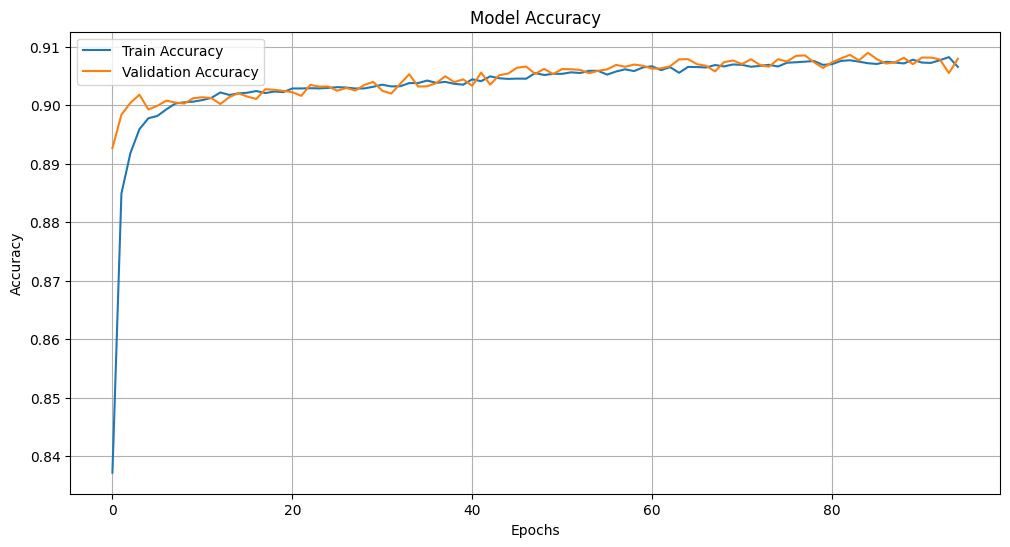

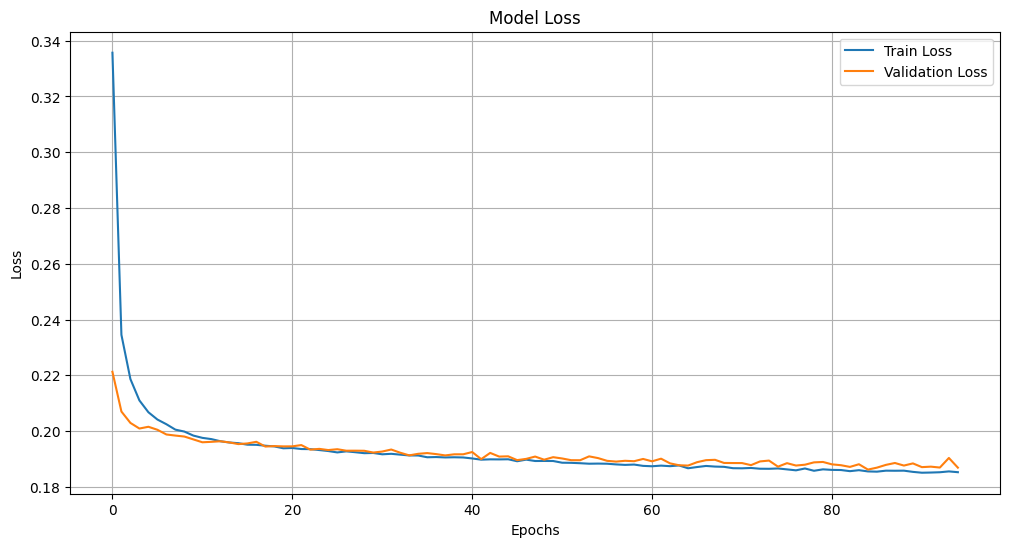

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
from sklearn.metrics import classification_report

print("Classification Report for Training Set:")
print(classification_report(y_train, y_train_pred))

print("Classification Report for Validation Set:")
print(classification_report(y_val, y_val_pred))

print("Classification Report for Test Set:")
print(classification_report(y_test, y_test_pred))

Classification Report for Training Set:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     89785
           1       0.86      0.94      0.90     66214

    accuracy                           0.91    155999
   macro avg       0.91      0.91      0.91    155999
weighted avg       0.91      0.91      0.91    155999

Classification Report for Validation Set:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     29929
           1       0.86      0.93      0.90     22071

    accuracy                           0.91     52000
   macro avg       0.91      0.91      0.91     52000
weighted avg       0.91      0.91      0.91     52000

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     29928
           1       0.86      0.93      0.90     22072

    accuracy                           0.91     52000
   macro a

In [34]:

df_extended['response_probability'] = classification_model.predict(X).flatten()

top_25_percent_subscribers = df_extended.nlargest(int(len(df_extended) * 0.25), 'response_probability')

df_extended.reset_index(drop=True, inplace=True)

campaign_response_rates = df_extended.pivot_table(index='customer_id', columns='campaign_id', values='response', aggfunc='mean')

top_25_percent_subscribers['optimal_campaign'] = top_25_percent_subscribers['customer_id'].apply(lambda x: campaign_response_rates.loc[x].idxmax())

unique_optimal_campaigns = top_25_percent_subscribers['optimal_campaign'].nunique()

print(f'Number of unique optimal campaigns: {unique_optimal_campaigns}')
print(f'Expected Response Rate for Week 27: {top_25_percent_subscribers["response_probability"].mean()}')
print(top_25_percent_subscribers[['customer_id', 'response_probability', 'optimal_campaign']])

8125/8125 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
Number of unique optimal campaigns: 10
Expected Response Rate for Week 27: 1.0
                    customer_id  response_probability  optimal_campaign
customer_id                                                            
1           49999             1                   1.0                 6
            59999             1                   1.0                 6
            69999             1                   1.0                 6
            149999            1                   1.0                 6
            159999            1                   1.0                 6
...                         ...                   ...               ...
3443        113441         3443                   1.0                 1
            123441         3443                   1.0                 1
            133441         3443                   1.0                 1
            143441         3443                   1.0                 1
            1

In [36]:
top_25_percent_subscribers[top_25_percent_subscribers['customer_id']==147].head(28)

week_id  customer_id  state_id  campaign_id  response  \
customer_id                                                                 
147         145           1          147         1            7         1   
            10145         2          147         1            8         0   
            20145         3          147         1            9         1   
            30145         4          147         1           10         0   
            40145         5          147         1            1         1   
            50145         6          147         1            2         0   
            60145         7          147         1            3         0   
            70145         8          147         1            4         0   
            80145         9          147         1            5         0   
            90145        10          147         1            6         1   
            100145       11          147         1            7         1   
            110145       12          147         1            8         0   
            120145       13          147         1            9         0   
            130145       14          147         1           10         0   
            140145       15          147         1            1         1   
            150145       16          147         1            2         0   
            160145       17          147         1            3         0   
            170145       18          147         1            4         1   
            180145       19          147         1            5         1   
            190145       20          147         1            6         1   
            200145       21          147         1            7         1   
            210145       22          147         1            8         0   
            220145       23          147         1            9         0   
            230145       24          147         1           10         0   
            240145       25          147         1            1         1   
            250145       26          147         1            2         0   

                    is_female  is_male  category_A  category_B  category_C  \
customer_id                                                                  
147         145             1        0       False       False        True   
            10145           1        0       False       False        True   
            20145           1        0       False       False        True   
            30145           1        0       False       False        True   
            40145           1        0       False       False        True   
            50145           1        0       False       False        True   
            60145           1        0       False       False        True   
            70145           1        0       False       False        True   
            80145           1        0       False       False        True   
            90145           1        0       False       False        True   
            100145          1        0       False       False        True   
            110145          1        0       False       False        True   
            120145          1        0       False       False        True   
            130145          1        0       False       False        True   
            140145          1        0       False       False        True   
            150145          1        0       False       False        True   
            160145          1        0       False       False        True   
            170145          1        0       False       False        True   
            180145          1        0       False       False        True   
            190145          1        0       False       False        True   
            200145          1        0       False       False        True   
            210145          1        0       False       False       

In [ ]:
df_extended['response_probability'] = classification_model.predict(scaler.transform(X))

campaign_response_rates = df_extended.pivot_table(index='customer_id', columns='campaign_id', values='response_probability', aggfunc='mean')

df_extended['optimal_campaign'] = df_extended['customer_id'].apply(lambda x: campaign_response_rates.loc[x].idxmax())

week_27_data = df_extended[df_extended['week_id'] == 26].copy()
week_27_data['week_id'] = 27
week_27_data['campaign_id'] = week_27_data['optimal_campaign']

features_for_prediction = X.columns
week_27_data_for_prediction = week_27_data[features_for_prediction]

week_27_scaled = scaler.transform(week_27_data_for_prediction)

week_27_data['response'] = (classification_model.predict(week_27_scaled) > 0.5).astype(int)

df_extended = pd.concat([df_extended, week_27_data[['customer_id', 'week_id', 'campaign_id', 'response']]], ignore_index=True)

week_response_rate = df_extended.groupby('week_id')['response'].mean()

plt.figure(figsize=(10, 6))
plt.plot(week_response_rate.index, week_response_rate.values, marker='o', linestyle='-')
plt.title('Week-wise Response Rate')
plt.xlabel('Week ID')
plt.ylabel('Response Rate')
plt.grid(True)
plt.show()


In [ ]:
week_response_rate

In [ ]:
"""import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import class_weight

def create_classification_model(input_shape):
    model = Sequential()
    model.add(Dense(128, input_shape=(input_shape,), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

input_shape = X_train_scaled.shape[1]
classification_model = create_classification_model(input_shape)
classification_model.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=['accuracy'])

y_train = y_train.values.astype(int)
y_val = y_val.values.astype(int)
y_test = y_test.values.astype(int)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = classification_model.fit(X_train_scaled, y_train, epochs=128,
                                   batch_size=64, validation_data=(X_val_scaled, y_val),
                                   callbacks=[early_stopping], class_weight=class_weight_dict)

y_train_pred = (classification_model.predict(X_train_scaled) > 0.5).astype(int)
y_val_pred = (classification_model.predict(X_val_scaled) > 0.5).astype(int)
y_test_pred = (classification_model.predict(X_test_scaled) > 0.5).astype(int)

print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")"""

In [ ]:
"""import eli5
from eli5.sklearn import PermutationImportance
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y, **fit_params):
        self.model.fit(X, y, **fit_params)
        return self

    def predict(self, X):
        return np.argmax(self.model.predict(X), axis=-1)

    def score(self, X, y):
        return self.model.evaluate(X, y, verbose=0)[1]

wrapped_model = KerasClassifierWrapper(classification_model)

perm = PermutationImportance(wrapped_model, random_state=116)

perm.fit(X_test_scaled, y_test)

eli5.show_weights(perm, feature_names=X_test.columns.tolist())
"""

In [ ]:
"""import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import classification_report

print("Classification Report for Training Set:")
print(classification_report(y_train, y_train_pred))

print("Classification Report for Validation Set:")
print(classification_report(y_val, y_val_pred))

print("Classification Report for Test Set:")
print(classification_report(y_test, y_test_pred))"""

### NN With BiLSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight

"""def create_classification_model(input_shape):
    model = Sequential()
    model.add(Conv1D(128, kernel_size=3, activation='relu', input_shape=(input_shape, 1)))
    model.add(BatchNormalization())
    
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    print(model.summary())
    return model"""

def create_classification_model(input_shape):
    model = Sequential()
    model.add(Conv1D(256, kernel_size=3, activation='relu', input_shape=(input_shape, 1)))
    model.add(BatchNormalization())

    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())

    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Bidirectional(LSTM(64)))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

X_train_processed = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_val_processed = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
X_test_processed = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

classification_model = create_classification_model(X_train_processed.shape[1])
classification_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

y_train = y_train.values.astype(int)
y_val = y_val.values.astype(int)
y_test = y_test.values.astype(int)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = classification_model.fit(X_train_processed, y_train, epochs=256,
                                   batch_size=64, validation_data=(X_val_processed, y_val),
                                   callbacks=[early_stopping], class_weight=class_weight_dict)

y_train_pred = (classification_model.predict(X_train_processed) > 0.5).astype(int)
y_val_pred = (classification_model.predict(X_val_processed) > 0.5).astype(int)
y_test_pred = (classification_model.predict(X_test_processed) > 0.5).astype(int)

print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")


In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import classification_report

print("Classification Report for Training Set:")
print(classification_report(y_train, y_train_pred))

print("Classification Report for Validation Set:")
print(classification_report(y_val, y_val_pred))

print("Classification Report for Test Set:")
print(classification_report(y_test, y_test_pred))